In [18]:
import pickle
import random
import numpy as np
from collections import Counter
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from functools import partial
import scipy.stats as stats
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
import os
import shutil
import matplotlib.lines as mlines
from matplotlib.collections import PathCollection
import matplotlib.patches as mpatches
from scipy.special import digamma
from collections import namedtuple

# Check if TeX is available
if shutil.which("pdflatex"):
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
    })
else:
    print("TeX not found, using default Matplotlib fonts.")

Dataset = namedtuple("Dataset", ["is_hallucination", "semantic_ids", "response_list", "token_log_probs", "p_false", "most_likely_answer", "questions", "contexts", "csd_fun"])

random.seed(42)
np.random.seed(42)


In [19]:
dataset_info = [
    ("nnnp-Llama-2-7b-chat--trivia_qa--results.pickle", "Llama-2", "Trivia QA"),
    ("nnnp-Llama-2-7b-chat--squad--results.pickle", "Llama-2", "Squad"),
    ("nnnp-Llama-2-7b-chat--nq--results.pickle", "Llama-2", "NQ"),
    ("nnnp-Llama-2-7b-chat--svamp--results.pickle", "Llama-2", "SVAMP"),
    ("nnnp-Llama-3.2-3B-Instruct--trivia_qa--results.pickle", "Llama-3.2", "Trivia QA"),
    ("nnnp-Llama-3.2-3B-Instruct--squad--results.pickle", "Llama-3.2", "Squad"),
    ("nnnp-Llama-3.2-3B-Instruct--nq--results.pickle", "Llama-3.2", "NQ"),
    ("nnnp-Llama-3.2-3B-Instruct--svamp--results.pickle", "Llama-3.2", "SVAMP"),
    ("nnnp-Mistral-Small-24B-Instruct-2501--trivia_qa--results.pickle", "Mistral", "Trivia QA" ),
    ("nnnp-Mistral-Small-24B-Instruct-2501--nq--results.pickle", "Mistral", "NQ" ),
    ("nnnp-Mistral-Small-24B-Instruct-2501--squad--results.pickle", "Mistral", "Squad" ),
    ("nnnp-Mistral-Small-24B-Instruct-2501--svamp--results.pickle", "Mistral", "SVAMP" ),
    ("nnnp-Llama-3.3-70B-Instruct--trivia_qa--results.pickle", "Llama-3.3-70B", "Trivia QA"),
]

no_of_train_prompts = 200 # number of prompts used to tune the estimator parameters (i.e. for the train set)
no_eval_seeds = 5 # numer of ranodm seeds to do evalulation on
num_mc_samples = 1000 # number of samples for Monte Carlo integration
truncate_no_semantic_classes = 7 # cutoff value for the number of semantic classes

In [20]:
def histogram_estimator(ds):
    semantic_ids = ds.semantic_ids

    def compute_entropy_naive(semantid_ids_row):
        cnt = Counter(semantid_ids_row)
        N = len(semantid_ids_row)
        entropy = 0.0
        for _,v in cnt.items():
            p = v / N
            entropy -= p * np.log(p)
        return entropy
    ea = np.array([ compute_entropy_naive(row) for row in semantic_ids])
    #print(ea.shape)
    return ea, np.zeros(len(semantic_ids))

def support_estimator(ds: Dataset):
    semantic_ids = ds.semantic_ids
    return np.array([ len(set(row)) for row in semantic_ids]), np.zeros(len(semantic_ids)), np.zeros(len(semantic_ids))

def p_true_estimator(ds: Dataset):
    pf = np.array(ds.p_false)
    #print(pf)
    return pf, np.zeros_like(pf)

def token_log_probs_to_prob(tp):
    return np.exp(np.array(tp).sum()).item()

def token_log_probs_to_prob_heuristic(tp):
    return np.exp(np.array(tp).mean()).item()

def ll_estimator(ds: Dataset):
    ll = np.array([ -token_log_probs_to_prob(mla['token_log_likelihoods']) for mla in ds.most_likely_answer ])
    #print(pf)
    return ll, np.zeros_like(ll)

In [21]:
def train_support_distribution(dataset): #TODO: refactor to only take smeantic IDs
    def get_train_semantic_ids(dataset):
        semantic_ids_train = dataset[1][:no_of_train_prompts,:] # for estimating support
        return semantic_ids_train
    
    semantic_ids_train = get_train_semantic_ids(dataset)
    
    support_sizes = np.array([ min(len(set(row)),truncate_no_semantic_classes) for row in semantic_ids_train ])
    support_size_counter = Counter(support_sizes)
    max_support = max(support_sizes)

    def prob_from_counter(count_support, count_all):
        return count_support / count_all
    
    train_support_histogram = list(map(lambda x: (x, prob_from_counter(support_size_counter[x], len(support_sizes))), range(1,max_support+1)))
    train_support_histogram = list(filter(lambda x: x[1] > 0.0, train_support_histogram))
    
    support_list, prob_list = zip(*train_support_histogram)
    train_support_histogram_indices = { s:i for i,s in enumerate(support_list) }
    

    def rescale_histogram(hist):
        s, probs = zip(*hist)
        probs_a = np.array(probs)
        new_probs = probs_a / probs_a.sum()
        return list(zip(s, new_probs.tolist()))

    def condition_support_distribution(min_support):
        if min_support >= max_support:
            return [(min_support, 1.0)]
        while min_support not in support_list:
            min_support += 1 

        starting_index = train_support_histogram_indices[min_support]
        rh = rescale_histogram(train_support_histogram[starting_index:]) # Bayes rule
        _, r_probs = zip(*rh)
        
        return rh

    return condition_support_distribution

    

In [22]:
data = {}


for pickle_name, llm_name, dataset_name in dataset_info:
    with open(pickle_name, 'rb') as file:
        loaded_dataset = pickle.load(file)
        gt_generations = loaded_dataset[1].shape[0] # how many prompts in the dataset
        csd_fun = train_support_distribution(loaded_dataset)
        data[(llm_name,dataset_name)] = Dataset._make(loaded_dataset + (csd_fun,))
        hallucination_fraction = data[(llm_name,dataset_name)].is_hallucination.mean()
        print(f"Have data for {gt_generations} prompts for {llm_name} LLM and the {dataset_name} dataset, hallucination fraction is {hallucination_fraction:.4f}.")

first_dataset = data[list(data.keys())[0]]

Have data for 1000 prompts for Llama-2 LLM and the Trivia QA dataset, hallucination fraction is 0.4070.
Have data for 1000 prompts for Llama-2 LLM and the Squad dataset, hallucination fraction is 0.7680.
Have data for 1000 prompts for Llama-2 LLM and the NQ dataset, hallucination fraction is 0.6470.
Have data for 300 prompts for Llama-2 LLM and the SVAMP dataset, hallucination fraction is 0.5900.
Have data for 1000 prompts for Llama-3.2 LLM and the Trivia QA dataset, hallucination fraction is 0.4570.
Have data for 1000 prompts for Llama-3.2 LLM and the Squad dataset, hallucination fraction is 0.7790.
Have data for 1000 prompts for Llama-3.2 LLM and the NQ dataset, hallucination fraction is 0.6090.
Have data for 300 prompts for Llama-3.2 LLM and the SVAMP dataset, hallucination fraction is 0.3767.
Have data for 1000 prompts for Mistral LLM and the Trivia QA dataset, hallucination fraction is 0.2250.
Have data for 1000 prompts for Mistral LLM and the NQ dataset, hallucination fraction is

In [23]:
def subsample_dataset(dataset, N, split='test',):
    is_hallucination_gt, semantic_ids_gt, response_list_gt, generated_token_log_probs_gt, p_false, mla, qs, cs, csd_fun = dataset
    gt_generations = semantic_ids_gt.shape[1] # how many generations was the LLM asked to make
    indices = [np.random.randint(low=0, high=gt_generations-1, size=N) for _ in range(len(response_list_gt))] 
    response_list = [[row[i] for i in indices[row_no]] for row_no, row in enumerate(response_list_gt)]
    generated_token_log_probs = [[row[i] for i in indices[row_no]] for row_no, row in enumerate(generated_token_log_probs_gt)]
    
    if split == 'test':
        ri = np.arange(no_of_train_prompts,semantic_ids_gt.shape[0])[:, np.newaxis]
        semantic_ids = semantic_ids_gt[ri, np.array(indices)[no_of_train_prompts:,:]]
        return Dataset._make((is_hallucination_gt[no_of_train_prompts:], semantic_ids, response_list[no_of_train_prompts:], generated_token_log_probs[no_of_train_prompts:], p_false[no_of_train_prompts:], mla[no_of_train_prompts:], qs[no_of_train_prompts:], cs[no_of_train_prompts:], csd_fun))
    elif split == 'train':
        ri = np.arange(0,no_of_train_prompts)[:, np.newaxis]
        semantic_ids = semantic_ids_gt[ri, np.array(indices)[:no_of_train_prompts,:]]
        return Dataset._make((is_hallucination_gt[:no_of_train_prompts], semantic_ids, response_list[:no_of_train_prompts], generated_token_log_probs[:no_of_train_prompts], p_false[:no_of_train_prompts], mla[:no_of_train_prompts], qs[:no_of_train_prompts], cs[:no_of_train_prompts], csd_fun))
    else:
        assert(False) # split has to be one of the specified values

def merge_datasets(dataset1, dataset2):
    is_hallucination_gt_1, semantic_ids_gt_1, response_list_gt_1, generated_token_log_probs_gt_1, p_false_1, mla, qs, cs, csd_fun_1 = dataset1
    is_hallucination_gt_2, semantic_ids_gt_2, response_list_gt_2, generated_token_log_probs_gt_2, p_false_2, mla2, qs2, cs2,  csd_fun_2 = dataset2

    semantic_ids_gt = np.concat((semantic_ids_gt_1, semantic_ids_gt_2), axis=1)
    response_list_gt = [ l1+l2 for l1,l2 in zip(response_list_gt_1, response_list_gt_2)]
    generated_token_log_probs_gt = [ l1+l2 for l1,l2 in zip(generated_token_log_probs_gt_1, generated_token_log_probs_gt_2)]

    return Dataset._make((is_hallucination_gt_1, semantic_ids_gt, response_list_gt, generated_token_log_probs_gt, p_false_1, mla, qs, cs, csd_fun_1))
      

In [24]:
def evaluate_one_seed(N, split, estimator, dataset, seed):
    random.seed(seed + 42)
    np.random.seed(seed + 42)
    ss_ds = subsample_dataset(dataset, N, split=split)
    semantic_entropy_estimates, _ = estimator(ss_ds)
    return roc_auc_score(ss_ds.is_hallucination, semantic_entropy_estimates)

In [25]:
def evaluate_estimator(N, estimator, dataset, split ='test', verbose=True):
    def get_mu_conf(l):
        array = np.array(l)
        mn = array.mean().item()
        conf = (1.96 *array.std() / np.sqrt(len(l))).item()
        return mn, conf
    

    auroc_list = Parallel(n_jobs=-1)(delayed(evaluate_one_seed)(N, split, estimator, dataset, seed) for seed in range(no_eval_seeds))
    auroc_res = get_mu_conf(auroc_list)
    
    if verbose:
        print(f"N={N} AUROC = {auroc_res[0]:.4f} +- {auroc_res[1]:.4f}.")
        
    return auroc_res

def evaluate_estimator_with_variance(estimator, dataset, seed, split ='test', verbose=True):
    random.seed(seed + 42)
    np.random.seed(seed + 42)
    
    N_lb = 1
    N_ub = 10

    entropies = dict()
    variances = dict()
    is_hallucination_l = dict()

    current_subsampled_dataset = subsample_dataset(dataset, N_lb, split=split)
    for N in range(N_lb,N_ub+1):
        semantic_entropy_estimates, variance_estimates = estimator(current_subsampled_dataset)
        entropies[N] = semantic_entropy_estimates
        variances[N] = variance_estimates
        is_hallucination_l[N] = current_subsampled_dataset.is_hallucination

        new_data = subsample_dataset(dataset, 1, split=split)
        current_subsampled_dataset = merge_datasets(current_subsampled_dataset, new_data)

    all_variances_list = list(variances.values())
    all_variances = np.concatenate(all_variances_list)
    variance_thresholds = np.unique(np.concat((np.array([0.0]),  np.percentile(all_variances, np.arange(0, 101, 1)))))
    
    result_list = []
    for threshold in variance_thresholds:
        threshold_entropies = []
        threshold_is_hallucinations = []
        threshold_N = []
        threshold_variances = []
        for row_index in range(len(is_hallucination_l[N_lb])):
            n = N_lb
            while variances[n][row_index] > threshold and n < N_ub:
                n += 1
            threshold_N.append(n)
            threshold_entropies.append(entropies[n][row_index])
            threshold_variances.append(variances[n][row_index])
            threshold_is_hallucinations.append(is_hallucination_l[n][row_index])
        
        average_N = np.array(threshold_N).mean()
        auroc = roc_auc_score(threshold_is_hallucinations, threshold_entropies)
        
        if verbose:
            print(f"Variance threshold {threshold:.8f}, Average N={average_N:.4f}, AUROC={auroc:.4f}" )
        result_list.append((average_N, auroc))

    return sorted(result_list, key=lambda x: x[0])


In [26]:
def total_prob_semantic_classes(semantic_ids, response_list, row_no, pg_row, are_heuristic_probs=False):    
    def answer_indices(row_no): # indices indexing of different answers 
        il = list(set(response_list[row_no]))
        r_to_i = { r:i for i,r in enumerate(il) }
        rv = [r_to_i[response] for response in response_list[row_no]]
        return np.array(rv)
    
    aid = answer_indices(row_no)

    probs = []
    probs_dict = {}
    set_total = set()

    sid_set = list(set(semantic_ids[row_no,:])) 

    for sid in sid_set:
        m_aid = aid[semantic_ids[row_no,:] == sid]
        relevant_aids = list(set(m_aid)) # distinct answers in a semantic class
        if len(set_total.intersection(relevant_aids)) > 0:
            print("Data inconsistent")
        set_total = set_total.union(relevant_aids)
        p = 0.0
        for raid in relevant_aids: 
            p += pg_row[raid == aid][:][0]
        probs.append(p)
        probs_dict[sid] = p

    probs = np.array(probs)
    sp = np.sum(probs)
    
    if sp > 1.01 and not are_heuristic_probs:
        print(f"Error in row {row_no}, pg_row={pg_row}, sp={sp}, sid_row={semantic_ids[row_no,:]}, aid={aid}")
    
    return probs, probs_dict



In [27]:
def rescaled_estimator(ds: Dataset, heuristic_scaling=False, add_one_class=False):
    semantic_ids = ds.semantic_ids
    generated_token_log_probs = ds.token_log_probs
    response_list = ds.response_list
    def rescaled_entropy_estimator_for_row(total_probs):
        total_probs = np.clip(total_probs, a_min=1e-4, a_max=None)
        total_probs /= total_probs.sum()
        return -(total_probs * np.log(total_probs)).sum()

    semantic_entropy_estimates = []
    for row_no in range(len(generated_token_log_probs)):
        if not heuristic_scaling:
            probs_generations = np.array([token_log_probs_to_prob(tl) for tl in generated_token_log_probs[row_no]])
        else:
            probs_generations = np.array([token_log_probs_to_prob_heuristic(tl) for tl in generated_token_log_probs[row_no]])
        
        total_probs, _ = total_prob_semantic_classes(semantic_ids, response_list, row_no, probs_generations, are_heuristic_probs=heuristic_scaling)
        if np.sum(total_probs) > 1.01 and not heuristic_scaling:
            print(ds.questions[row_no])
            print(ds.contexts[row_no])
            print(probs_generations)
            print(generated_token_log_probs[row_no])
            print(response_list[row_no])

        if add_one_class:
            if np.sum(total_probs) < 1.0: 
                total_probs = np.concat((total_probs, np.array([1.0 - np.sum(total_probs)])))

        estimated_semantic_entropy_for_row = rescaled_entropy_estimator_for_row(total_probs)
        semantic_entropy_estimates.append(estimated_semantic_entropy_for_row)
    
    return np.array(semantic_entropy_estimates), np.zeros(len(semantic_ids))

In [28]:
def entropy(p_vector):
    assert(np.all(p_vector >= 0))
    eps = 1e-6
    p_vector_clipped = p_vector.clip(min=eps)
    return -np.where(p_vector > eps, p_vector_clipped * np.log(p_vector_clipped), 0.0).sum(axis=1)


def sample_truncated_uniform_simplex(lower_bounds, size=100, eps=1e-2):

    lower_bounds = np.clip(lower_bounds, a_min=0.0, a_max=1.0)
    if lower_bounds.sum() >= 1 - eps:
         lower_bounds *= (1 - eps) / lower_bounds.sum() 
         
    residual_simplex_size = 1 - np.sum(lower_bounds)
    y = np.random.dirichlet(np.ones_like(lower_bounds), size=size)
    y_scaled = y * residual_simplex_size
    x = y_scaled + lower_bounds[:]
    return x

def mean_var_entropy_stable_self_normalized_truncated_dirichlet(alpha, lower_bounds, num_samples=num_mc_samples):
    samples = sample_truncated_uniform_simplex(lower_bounds=lower_bounds, size=num_samples)
    log_weights = stats.dirichlet.logpdf(samples.T, alpha)

    log_weights_centered = log_weights - np.max(log_weights)
    weights = np.exp(log_weights_centered)
    sn_constant = np.sum(weights)

    entropy_vector = entropy(samples)
    mean_entropy = np.sum(weights * entropy_vector) / sn_constant
    second_moment = np.sum(weights * entropy_vector**2) / sn_constant
    
    var_entropy = second_moment - mean_entropy**2
    return mean_entropy, var_entropy

def expected_entropy_dirichlet(alpha):
    alpha = np.array(alpha)
    alpha_0 = np.sum(alpha)
    
    term1 = digamma(alpha_0 + 1)
    term2 = np.sum((alpha / alpha_0) * digamma(alpha + 1))
    
    return term1 - term2

def bayes_entropy_support_belief_with_log_probs_row(semantic_ids_row, total_probs_dict, dirichlet_prior, condition_support_distribution, use_probs):
    min_support_size = len(set(semantic_ids_row))
    cnt = Counter(semantic_ids_row)
    cnt_list = np.array(list(cnt.values()))
    
    total_eh = 0.0
    total_varh = 0.0
    
    for support_size, prob_of_support in condition_support_distribution(min_support_size):
        min_probs = np.zeros(support_size)
        if use_probs:
            for i,k in enumerate(cnt.keys()):
                min_probs[i] = total_probs_dict[k]

        alpha = np.ones((support_size)) * dirichlet_prior
        alpha[:len(cnt_list)] += cnt_list
        eh, varh = mean_var_entropy_stable_self_normalized_truncated_dirichlet(alpha, min_probs)
        
        total_eh += eh * prob_of_support
        total_varh += (eh**2 + varh) * prob_of_support
        
    total_varh -= total_eh**2

    return total_eh, total_varh

def bayes_estimator(ds : Dataset, dirichlet_prior, use_probs=True):
    semantic_ids = ds.semantic_ids
    response_list = ds.response_list
    generated_token_log_probs = ds.token_log_probs
    csd_fun = ds.csd_fun
    
    semantic_entropy_estimates = []
    variance_estimates = []
    
    for row_no in range(len(semantic_ids)):
        probs_generations = np.array([token_log_probs_to_prob(tl) for tl in generated_token_log_probs[row_no]])
        _, total_probs_dict = total_prob_semantic_classes(semantic_ids, response_list, row_no, probs_generations)
        estimated_semantic_entropy_for_row, var_per_row = bayes_entropy_support_belief_with_log_probs_row(
            semantic_ids[row_no], total_probs_dict=total_probs_dict, dirichlet_prior=dirichlet_prior, condition_support_distribution=csd_fun, use_probs=use_probs)
        semantic_entropy_estimates.append(estimated_semantic_entropy_for_row)
        variance_estimates.append(var_per_row)
        
    return np.array(semantic_entropy_estimates), np.array(variance_estimates)


In [29]:
compared_estimators = [
    ("SE-Histogram", histogram_estimator),
    ("SE-Rescaled", rescaled_estimator),
    ("SE-Rescaled (h)", partial(rescaled_estimator, heuristic_scaling=True)),
    #("Rescaled (add)", partial(rescaled_estimator, add_one_class=True)),
    #("Support", support_estimator),
    ("P(true)", p_true_estimator),
    ("LL", ll_estimator),
    #("Bayes SE (NP)", partial(bayes_estimator, dirichlet_prior=0.5, use_probs=False)),
    ("SE-Bayes", partial(bayes_estimator, dirichlet_prior=0.5))
]

In [30]:
def make_results_table(N):
    print(f"N = {N}")
    llm_names = sorted(list(set(map(lambda x: x[0], data.keys()))))
    dataset_names = sorted(list(set(map(lambda x: x[1], data.keys()))))

    results_dict = {}

    for llm_name in llm_names:
        print(f"  LLM name: {llm_name}")
        for dataset_name in dataset_names:
            print(f"    Dataset name: {dataset_name}")
            if (llm_name, dataset_name) not in data:
                print("    no data")
            else:
                for estimator_name, estimator_fun in compared_estimators:
                    results = []
                    auroc_result = evaluate_estimator(N,estimator_fun,data[llm_name, dataset_name], split='test', verbose=False)
                    print(f"      {estimator_name}:  AUROC = {auroc_result[0]:.4f} +- {auroc_result[1]:.4f}")
                    results_dict[llm_name, dataset_name, estimator_name] = auroc_result
                    
    return results_dict

def generate_latex_table(results_dict, filename):
    """
    Generates LaTeX code for a table reporting experiment results with merged LLM name cells and highlighted best values.
    Writes the output to a file in the results subdirectory.
    
    :param results_dict: Dictionary with keys (llm_name, dataset_name, estimator_name) and values as (mean, error_bar)
    :param filename: Name of the file to write the LaTeX output
    """
    
    # Ensure results directory exists
    results_dir = "results"
    os.makedirs(results_dir, exist_ok=True)
    file_path = os.path.join(results_dir, filename)
    
    # Extract unique values for LLMs, datasets, and estimators
    llm_names = sorted(set(key[0] for key in results_dict.keys()))
    dataset_names = sorted(set(key[1] for key in results_dict.keys()))
    estimator_names = sorted(set(key[2] for key in results_dict.keys()))
    
    # Count occurrences of each LLM for row merging
    llm_counts = {llm: sum(1 for key in results_dict.keys() if key[0] == llm) // len(estimator_names) for llm in llm_names}

    # Begin LaTeX table
    estimator_columns = ["c"] * len(estimator_names)
    # replace 'c' with 'g' (custom column with gray background) if estimator_name is 'SE-Bayes'
    for i, estimator in enumerate(estimator_names):
        if estimator == 'SE-Bayes':
            estimator_columns[i] = 'g'
    
    estimator_columns = ''.join(estimator_columns)

    latex_code = "\\begin{tabular}{ll" + estimator_columns + "} \n"
    latex_code += "\\hline\n"
    
    # Column headers
    latex_code += "LLM & Dataset "
    for estimator in estimator_names:
        latex_code += f" & {estimator}"
    latex_code += " \\\\ \n\\hline\n"
    
    # Fill in table rows
    for llm in llm_names:
        first_row = True
        for dataset in dataset_names:
            # Get row values
            row_values = {estimator: results_dict.get((llm, dataset, estimator), None) for estimator in estimator_names}
            
            if all(value is None for value in row_values.values()):
                continue

            if first_row:
                latex_code += f"\\multirow{{{llm_counts[llm]}}}{{*}}{{{llm}}} "
                first_row = False
            else:
                latex_code += " "
            latex_code += f" & {dataset} "
            
            
            # Find the best value and its confidence range
            best_value = max((v[0] for v in row_values.values() if v is not None), default=None)
            best_range = (best_value, best_value)   
            
            if best_value is not None:
                for estimator, result in row_values.items():
                    if result is not None and result[0] == best_value:
                        best_range = (best_value - result[1], best_value + result[1])
                        break  # Only need to set this once
            
            for estimator in estimator_names:
                result = row_values[estimator]
                if result is None:
                    latex_code += " & no data"
                else:
                    mean, error = result                    
                    if mean + error >= best_range[0]:
                        latex_code += f" & $\\mathbf{{{mean:.3f} \pm {error:.3f}}}$"
                    else:
                        latex_code += f" & ${mean:.3f} \pm {error:.3f}$"
            latex_code += " \\\\ \n" 
        latex_code += " \hline \n"
    
    # End table
    #latex_code += "\\hline\n"
    latex_code += "\\end{tabular}\n"
    
    # Write to file
    with open(file_path, "w") as f:
        f.write(latex_code)

results_for_N = {}
for N in range(1,10+1):
    results = make_results_table(N)
    generate_latex_table(results, f"results_auroc_n_{N}.tex")
    results_for_N[N] = results

N = 1
  LLM name: Llama-2
    Dataset name: NQ
      SE-Histogram:  AUROC = 0.5000 +- 0.0000
      SE-Rescaled:  AUROC = 0.5000 +- 0.0000
      SE-Rescaled (h):  AUROC = 0.5000 +- 0.0000
      P(true):  AUROC = 0.4610 +- 0.0000
      LL:  AUROC = 0.5829 +- 0.0000
      SE-Bayes:  AUROC = 0.6693 +- 0.0127
    Dataset name: SVAMP
      SE-Histogram:  AUROC = 0.5000 +- 0.0000
      SE-Rescaled:  AUROC = 0.5000 +- 0.0000
      SE-Rescaled (h):  AUROC = 0.5000 +- 0.0000
      P(true):  AUROC = 0.4690 +- 0.0000
      LL:  AUROC = 0.6309 +- 0.0000
      SE-Bayes:  AUROC = 0.7961 +- 0.0572
    Dataset name: Squad
      SE-Histogram:  AUROC = 0.5000 +- 0.0000
      SE-Rescaled:  AUROC = 0.5000 +- 0.0000
      SE-Rescaled (h):  AUROC = 0.5000 +- 0.0000
      P(true):  AUROC = 0.4408 +- 0.0000
      LL:  AUROC = 0.6244 +- 0.0000
      SE-Bayes:  AUROC = 0.7010 +- 0.0088
    Dataset name: Trivia QA
      SE-Histogram:  AUROC = 0.5000 +- 0.0000
      SE-Rescaled:  AUROC = 0.5000 +- 0.0000
      SE-

In [31]:
# colors = ['#109f8f', '#0077bb', 'tab:red', '#ee3679', '#3bbdee', ]
colors = ['tab:blue',
          'tab:orange',
        #   'tab:green', 
          '#109f8f',
          'tab:red', 
          'tab:purple', 
          'tab:brown',
          'tab:pink',
          'tab:gray',
          'tab:olive',
          'tab:cyan']

LLM name: Llama-2
  Dataset name: NQ


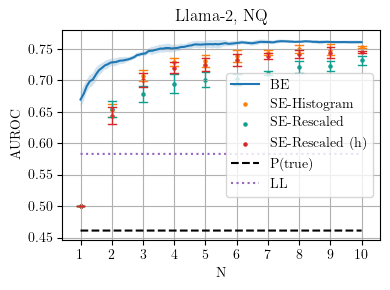

  Saving for Llama-2, NQ: 0.42x
  Dataset name: SVAMP


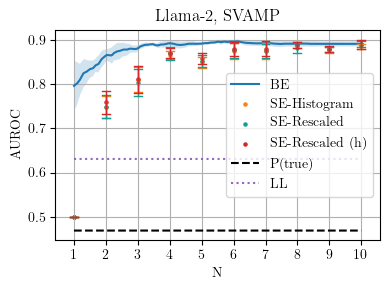

  Saving for Llama-2, SVAMP: 0.31x
  Dataset name: Squad


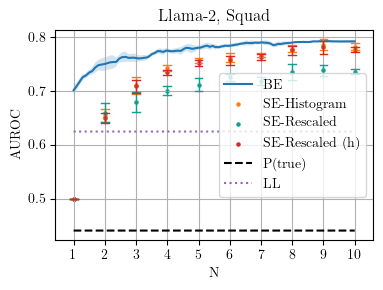

  Saving for Llama-2, Squad: 0.51x
  Dataset name: Trivia QA


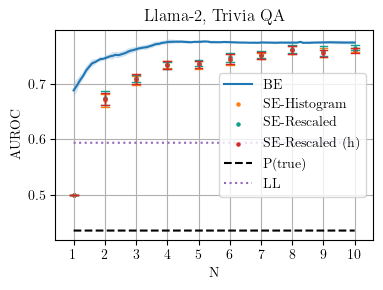

  Saving for Llama-2, Trivia QA: 0.29x
LLM name: Llama-3.2
  Dataset name: NQ


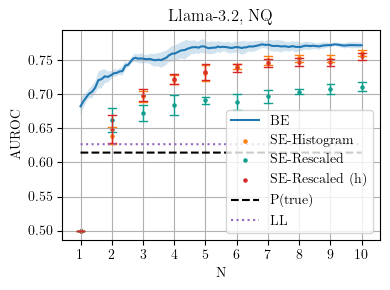

  Saving for Llama-3.2, NQ: 0.41x
  Dataset name: SVAMP


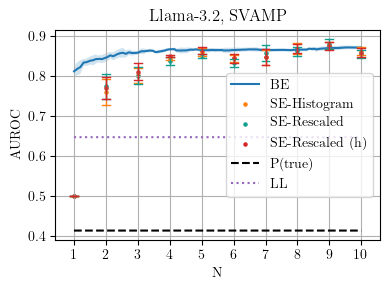

  Saving for Llama-3.2, SVAMP: 0.31x
  Dataset name: Squad


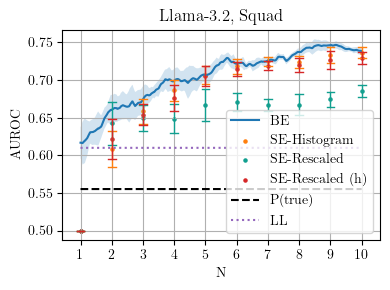

  Saving for Llama-3.2, Squad: 0.79x
  Dataset name: Trivia QA


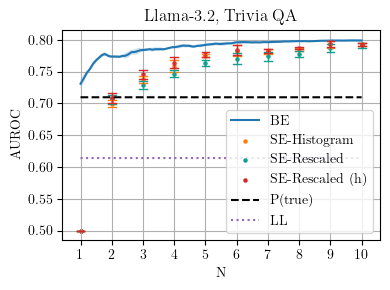

  Saving for Llama-3.2, Trivia QA: 0.51x
LLM name: Llama-3.3-70B
  Dataset name: NQ
    no data
  Dataset name: SVAMP
    no data
  Dataset name: Squad
    no data
  Dataset name: Trivia QA


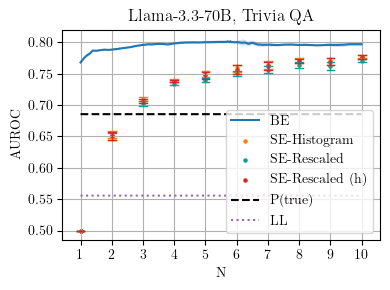

  Saving for Llama-3.3-70B, Trivia QA: 0.12x
LLM name: Mistral
  Dataset name: NQ


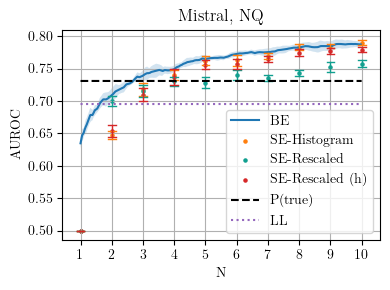

  Saving for Mistral, NQ: 1.00x
  Dataset name: SVAMP


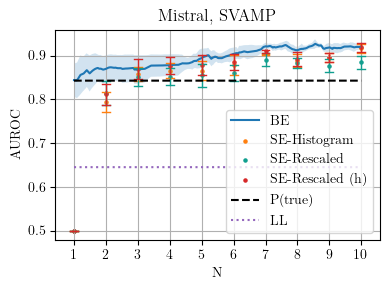

  Saving for Mistral, SVAMP: 0.69x
  Dataset name: Squad


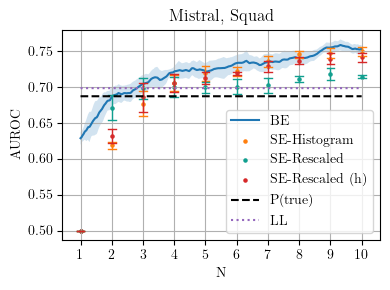

  Saving for Mistral, Squad: 0.87x
  Dataset name: Trivia QA


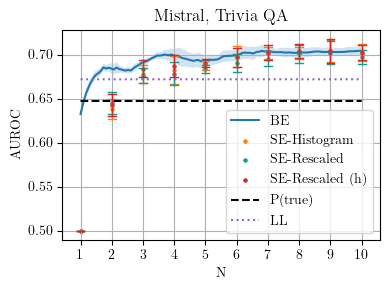

  Saving for Mistral, Trivia QA: 0.66x
Average saving: 0.53x


In [32]:
def interpolate(data, N_values_grid):
    data = sorted(data)
    N_values = np.array([pair[0] for pair in data])
    y = np.array([pair[1] for pair in data])

    N_unique, indices, counts = np.unique(N_values, return_inverse=True, return_counts=True)
    y_unique = np.bincount(indices, weights=y) / counts

    sorted_indices = np.argsort(N_unique)
    N_sorted = N_unique[sorted_indices]
    y_sorted = y_unique[sorted_indices]

    interpolate_func = interp1d(N_sorted, y_sorted, kind='linear', fill_value="extrapolate")
    interpolated_auroc = interpolate_func(N_values_grid)
    return interpolated_auroc

def plot_points(data, color, label):
    N_values = [item[0] for item in data]           # Extract N values
    mu_values = [item[1][0] for item in data]       # Extract mu values (y-coordinates)
    conf_values = [item[1][1] for item in data]     # Extract conf values (confidence widths)

    plt.scatter(N_values, mu_values, color=color, label=label, s=5)

    for N, mu, conf in zip(N_values, mu_values, conf_values):
        plt.plot([N, N], [mu - conf, mu + conf], color=color, lw=1)  # Vertical confidence bar
        plt.plot([N - 1/8, N + 1/8], [mu - conf, mu - conf], color=color, lw=1)  # Bottom cap
        plt.plot([N - 1/8, N + 1/8], [mu + conf, mu + conf], color=color, lw=1)  # Top cap


def plot_baseline(name, name_tuple, color):
    res = [ (N, results_for_N[N][name_tuple + (name,)]) for N in range(1,10 + 1) ]
    plot_points(res, color, name)

def save_legend_markers_to_files(legend):
    handles, labels = legend.legend_handles, [t.get_text() for t in legend.get_texts()]

    for handle, label in zip(handles, labels):
        fig_marker, ax_marker = plt.subplots(figsize=(1, 0.33))  # Small figure for the marker
        #fig_marker.tight_layout()
        if isinstance(handle, mlines.Line2D):
            rect = mpatches.Rectangle((-1, -1), 2, 2, facecolor=handle.get_color(), alpha=0.2, edgecolor="none")  
            if handle.get_color() not in ["black", "blue", "tab:purple"]:
                ax_marker.add_patch(rect)
            ax_marker.plot([-1, 1], [0, 0], color=handle.get_color(), linestyle=handle.get_linestyle(),
                       marker=handle.get_marker(), markersize=handle.get_markersize())
            
        elif isinstance(handle, PathCollection):
            offsets = np.array([0, 0])  # Position marker at the center
            facecolors = handle.get_facecolors()  # Get face color of the scatter marker
            edgecolors = handle.get_edgecolors()  # Get edge color of the scatter marker
            sizes = handle.get_sizes()  # Get marker size
            size = np.sqrt(sizes[0]) if sizes.size > 0 else 10  

            fc = facecolors[0] if len(facecolors) > 0 else 'black'

            ax_marker.scatter(offsets[0], offsets[1], s=size*20, 
                            facecolor=fc, 
                            edgecolor=edgecolors[0] if len(edgecolors) > 0 else 'black')
            
            conf = 0.8  # Fixed confidence range for legend marker
            vsize2 = 0.6 
            ax_marker.plot([-conf, conf], [0, 0], color=fc, lw=2)  # Horizontal confidence bar
            ax_marker.plot([-conf, -conf], [-vsize2, vsize2], color=fc, lw=2)  # Left cap
            ax_marker.plot([conf, conf], [-vsize2, vsize2], color=fc, lw=2)  # Right cap
        
        ax_marker.set_xlim(-1, 1)  # Keep marker centered
        ax_marker.set_ylim(-1, 1)
        ax_marker.margins(0.5)
        ax_marker.axis("off")  # Hide axes
        
        # Save marker separately
        fig_marker.savefig(f"results/legend_marker_{label}.pdf", bbox_inches="tight", transparent=True)
        plt.close(fig_marker)

def find_saving(name_tuple, mean_val, N_values_grid): # budget saving relative to histogram with N = 10 
    reference_N = 10
    reference_auroc = results_for_N[reference_N][name_tuple + ("SE-Histogram",)][0]
    #print(reference_auroc)
    i = 0
    while i<len(mean_val) and mean_val[i] < reference_auroc:
        i += 1
    i = min(i, len(mean_val)-1)
    return N_values_grid[i] / reference_N

def adaptive_sampling_plot(name_tuple, dirichlet_prior=0.5):
    estimator = partial(bayes_estimator, dirichlet_prior=dirichlet_prior)
    var_plots = Parallel(n_jobs=-1)(delayed(evaluate_estimator_with_variance)(estimator, data[name_tuple], seed, split='test', verbose=False) for seed in range(no_eval_seeds))
    
    N_values_grid = np.linspace(1.0, 10.0, 2000)

    vals = []
    for var_plot in var_plots:
        #print(var_plot)
        vals.append(interpolate(var_plot, N_values_grid))
    
    vals = np.array(vals)
    mean_val = vals.mean(axis=0) 
    mean_conf = 1.96 * vals.std(axis=0) / np.sqrt(len(var_plots)) 
        
    def plot_data(save_figure, has_legend):
        plt.grid(True)
        plt.plot(N_values_grid, mean_val, marker=' ', linestyle='-', color=colors[0], label='BE')
        plt.fill_between(N_values_grid, mean_val - mean_conf, mean_val+mean_conf, color=colors[0], edgecolor='none', alpha=0.2)
    
        plot_baseline("SE-Histogram", name_tuple, colors[1])
        plot_baseline("SE-Rescaled", name_tuple, colors[2])
        plot_baseline("SE-Rescaled (h)", name_tuple, colors[3])
 
        p_true_val = results_for_N[1][name_tuple + ("P(true)",)][0] * np.ones_like(N_values_grid)
        ll_val = results_for_N[1][name_tuple + ("LL",)][0] * np.ones_like(N_values_grid)
        
        plt.plot(N_values_grid, p_true_val, linestyle="--", color="black", label="P(true)")
        plt.plot(N_values_grid, ll_val, linestyle="dotted", color="tab:purple", label="LL")

        plt.xlabel("N")
        plt.ylabel("AUROC")
        #plt.ylim((0.5 - 0.02, 0.82 + 0.02))
        
        plt.title(f"{name_tuple[0]}, {name_tuple[1]}")
        if has_legend:
            plt.legend()
            save_legend_markers_to_files(plt.gca().get_legend())
        
        plt.xticks(range(1, 11))
        plt.tight_layout()
        if save_figure:
            os.makedirs('results', exist_ok=True)
            plt.savefig(f'results/Adaptive_Sampling_auroc_{name_tuple[0]}_{name_tuple[1]}_{dirichlet_prior}.pdf', format='pdf')
    
    #plt.ioff()
    f_no_legend = plt.figure(figsize=(4, 3))
    plot_data(save_figure=True, has_legend=False)
    plt.close(f_no_legend)

    f_legend = plt.figure(figsize=(4, 3))
    plot_data(save_figure=False, has_legend=True)
    plt.show()

    saving = find_saving(name_tuple, mean_val, N_values_grid)
    print(f"  Saving for {name_tuple[0]}, {name_tuple[1]}: {saving:.2f}x")

    return saving


def make_adaptive_sampling_plots():
    llm_names = sorted(list(set(map(lambda x: x[0], data.keys()))))
    dataset_names = sorted(list(set(map(lambda x: x[1], data.keys()))))
    savings = []

    for llm_name in llm_names:
        print(f"LLM name: {llm_name}")
        for dataset_name in dataset_names:
            print(f"  Dataset name: {dataset_name}")
            if (llm_name, dataset_name) not in data:
                print("    no data")
            else:
                saving = adaptive_sampling_plot((llm_name, dataset_name))
                savings.append(saving)
    
    print(f"Average saving: {np.mean(savings):.2f}x")
                

make_adaptive_sampling_plots()

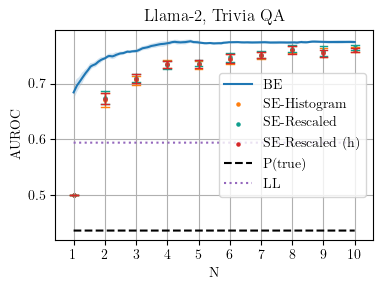

  Saving for Llama-2, Trivia QA: 0.31x


np.float64(0.312056028014007)

In [33]:
# ablation on prior parameters
adaptive_sampling_plot(("Llama-2", "Trivia QA"), dirichlet_prior=0.1)

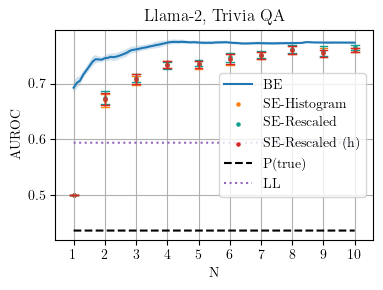

  Saving for Llama-2, Trivia QA: 0.29x


np.float64(0.2917958979489745)

In [34]:
adaptive_sampling_plot(("Llama-2", "Trivia QA"), dirichlet_prior=1.0)